# PCA & Clustering
---

In [67]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
# func 모음

# 1. 종목코드를 6자리로 통일. ex) 990 -> 000990
def padding(x):
    return x.rjust(6, "0")

---
# 1. PCA

## 1-1. Data

In [199]:
df = pd.read_csv("./datasets/preprocessed_final.csv", index_col=0)
df["종목코드"] = df["종목코드"].astype("str")
df["종목코드"] = df["종목코드"].map(padding)
df

,종목코드,회사명,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,종목명,PER,PBR,시가총액
0,000990,(주)DB하이텍,0.028653,4.113681,2.670785,174.09,48.29,0.445142,49.648820,DB하이텍,23.36,3.89,2499641.0
1,023150,(주)MH에탄올,-0.301897,-0.000000,1.253321,117.69,69.27,0.081587,1.717932,MH에탄올,0.00,1.12,64267.0
2,002360,(주)SH에너지화학,0.361237,-0.000000,1.143522,917.82,29.79,0.166757,10.246872,SH에너지화학,0.00,1.07,104466.0
3,009160,(주)SIMPAC,0.176695,-0.571031,0.779131,125.85,51.22,0.174309,27.341287,SIMPAC,20.64,0.48,211992.0
4,100840,(주)SNT에너지,0.779873,0.073893,0.577712,257.09,40.37,0.131054,21.178235,SNT에너지,8.24,0.54,132869.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,000850,화천기공(주),0.763649,7.384076,0.567872,341.83,24.95,0.077436,17.755082,화천기공,10.23,0.26,76230.0
842,016580,환인제약(주),0.537149,3.277122,1.954171,798.20,11.09,0.105514,11.548340,환인제약,14.69,1.22,334801.0
843,094280,효성아이티엑스(주),-0.235806,1.557279,0.485197,63.82,227.69,0.222635,21.623614,효성ITX,22.47,4.85,233476.0
844,205470,휴마시스(주),0.099311,-0.000000,4.392172,439.90,39.94,0.530306,16.946579,휴마시스,0.00,12.50,231353.0


In [200]:
## PCA를 위한 데이터 구분 / 수치형 변수들로만 구성된 data로 PCA 수행
df_obj = df.select_dtypes(include='object')
df_num = df.select_dtypes(exclude='object')

# column에 PCA를 적용하기 이전에 scaling을 진행 / eigenvalue를 확인
scaler = StandardScaler()
scaled_ds = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns)
scaled_ds.head()

,NCAV,PEGR,PSR,유동비율,부채비율,일일변동평균,샤프지수,PER,PBR,시가총액
0,0.096924,0.987483,-0.115637,-0.333705,-0.356493,0.857063,1.083739,-0.140511,0.903997,0.025080
1,-0.483167,0.135456,-0.292114,-0.515496,-0.048657,-1.162791,-1.229959,-0.401798,-0.370938,-0.112188
2,0.680584,0.135456,-0.305784,2.063518,-0.627940,-0.689599,-0.818254,-0.401798,-0.393951,-0.109923
3,0.356727,0.017184,-0.351151,-0.489194,-0.313501,-0.647641,0.006920,-0.170935,-0.665508,-0.103862
4,1.415260,0.150761,-0.376228,-0.066176,-0.472702,-0.887961,-0.290580,-0.309631,-0.637892,-0.108322


## 1-2. 주성분 설명력 확인

In [201]:
df_pca = pd.DataFrame((eigen_vals/tot), index=scaled_ds.columns, columns=["설명력"])
df_pca.sort_values(by=["설명력"])
df_pca

,설명력
NCAV,0.211058
PEGR,0.193316
PSR,0.131347
유동비율,0.119815
부채비율,0.099576
일일변동평균,0.082657
샤프지수,0.016518
PER,0.035819
PBR,0.056520
시가총액,0.053373


/var/folders/x3/lny9bbwx64b561c29r4y4z400000gn/T/ipykernel_9755/3091184214.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


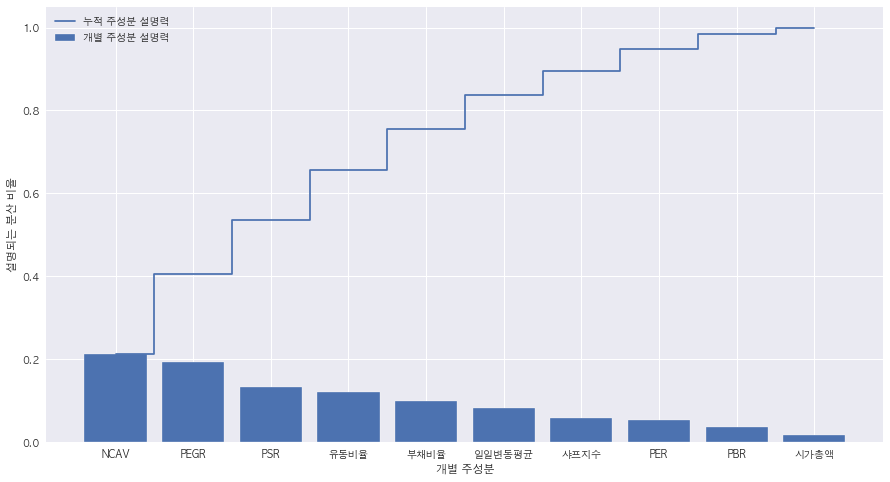

In [202]:
# PCA로 설명되는 분산을 계산 & plot
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
plt.style.use('seaborn')
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams['figure.figsize'] = [15, 8]

cov_mat = np.cov(scaled_ds.T) # 각 열에 대해 공분산 계산
eigen_vals, _ = np.linalg.eig(cov_mat) # 공분산의 고유값, 고유벡터 계산. (PCA에서의 분산 = 고유값)
tot=sum(eigen_vals) 

var_exp=[(i/tot) for i in sorted(eigen_vals,reverse=True)] # 개별 주성분 설명력(고유값 / 전체 고유값). 공분산의 고유값이 높은 순서대로 계산(%)
cum_var_exp=np.cumsum(var_exp) # 누적 주성분 설명력

plt.bar(scaled_ds.columns, var_exp, label='개별 주성분 설명력')
plt.step(scaled_ds.columns,cum_var_exp, where='mid', label='누적 주성분 설명력')
plt.ylabel('설명되는 분산 비율')
plt.xlabel('개별 주성분')
plt.legend(loc='best')

In [203]:
# 주성분별 설명력 & 누적 설명력
## 6개 이상일 때 누적설명력이 0.8을 넘음
data = {"설명력":list(eigen_vals/tot), "누적설명력": list(cum_var_exp)}
df_pca = pd.DataFrame(data, index=scaled_ds.columns)
df_pca.sort_values(by=["설명력"])
df_pca

,설명력,누적설명력
NCAV,0.211058,0.211058
PEGR,0.193316,0.404374
PSR,0.131347,0.535721
유동비율,0.119815,0.655536
부채비율,0.099576,0.755112
일일변동평균,0.082657,0.837769
샤프지수,0.016518,0.894289
PER,0.035819,0.947663
PBR,0.056520,0.983482
시가총액,0.053373,1.000000


In [236]:
# 분산 80%이상을 설명하는 주성분 갯수( = PCA 차원 수)
pca = PCA()
pca.fit(scaled_ds)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.80) + 1
d

6

## 1-3. PCA : 차원축소

In [237]:
# 분산 누적 설명량이 80% 이상 도달하는 6차원으로 축소
pca = PCA(n_components=5, random_state=100)
PCA_ds = pd.DataFrame(pca.fit_transform(scaled_ds), columns=(['PC1', 'PC2', 'PC3', 'PC4', 'PC5']))
PCA_ds

,PC1,PC2,PC3,PC4,PC5
0,0.516872,1.324843,-1.027027,-0.026448,0.130861
1,-0.257663,-1.852913,-0.116521,0.285218,0.013938
2,-2.120629,-0.383344,-0.177704,-0.461681,-0.106295
3,-0.313063,-0.696681,0.034869,-0.568150,0.181508
4,-1.315988,-0.660653,-0.086664,-0.726747,0.234847
...,...,...,...,...,...
841,-1.761517,-0.937878,-1.129403,-0.484312,0.256418
842,-2.372281,-0.466153,-0.555015,-0.229212,-0.012281
843,1.639205,-0.731900,-0.454511,1.121086,-0.287934
844,-0.186825,2.405234,-0.885518,2.294603,-0.496585


## 1-4. PCA 주성분과 변수들의 상관관계

In [238]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
# loadings.shape
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],
                            index=scaled_ds.columns)

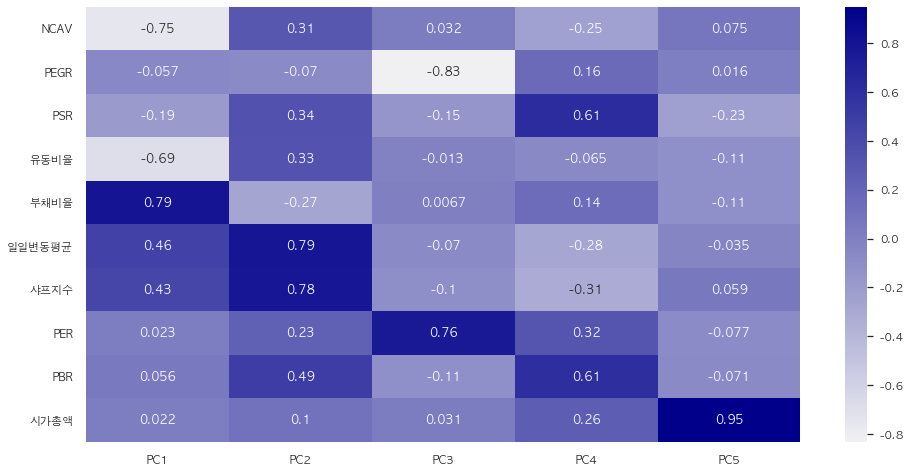

In [239]:
cmap = sns.light_palette("DarkBlue", as_cmap = True)
sns.set(font="AppleGothic",rc = {'figure.figsize':(16,8)})  
sns.heatmap(loading_matrix, annot = True, cmap = cmap)
plt.show()

[각각의 주성분들을 대표하는 변수, 절댓값 0.5이상]
- PC1 : NCAV, 유동비율, 부채비율
- PC2 : 일일변동평균, 샤프지수
- PC3 : PEGR, PER
- PC4 : PSR, PBR
- PC5 : 시가총액

---
# 2. 클러스터링

## 2-1. 클러스터 수 k 결정

### 2-1-1. Elbow Method
- 파란색 : 각 데이터들의 군집 중심과의 평균 거리
- 초록색 : 학습 시간

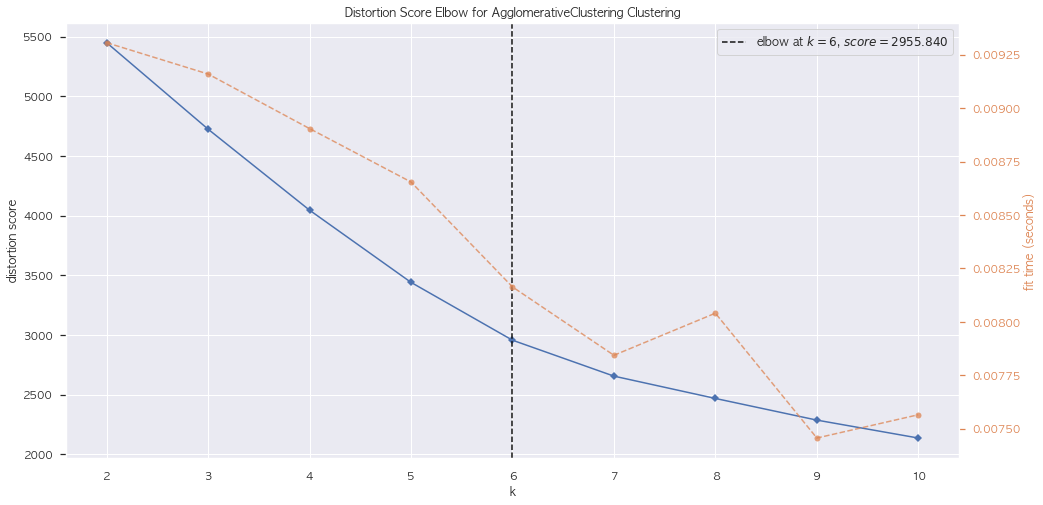

<AxesSubplot: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [244]:
# distortion score : 각 클러스터 중심으로부터 데이터간의 거리의 제곱합
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering

# Elbow_M = KElbowVisualizer(KMeans(random_state = 100), k=10, metric = 'distortion') #Kmeans
Elbow_M = KElbowVisualizer(AgglomerativeClustering(linkage='ward'), k=10, metric = 'distortion') # AgglomerativeClustering
Elbow_M.fit(PCA_ds)
Elbow_M.show()

### 2-1-2. Silhouette

In [245]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 

    from sklearn.cluster import AgglomerativeClustering
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = AgglomerativeClustering(n_clusters = n_cluster, linkage='ward')
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                            'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

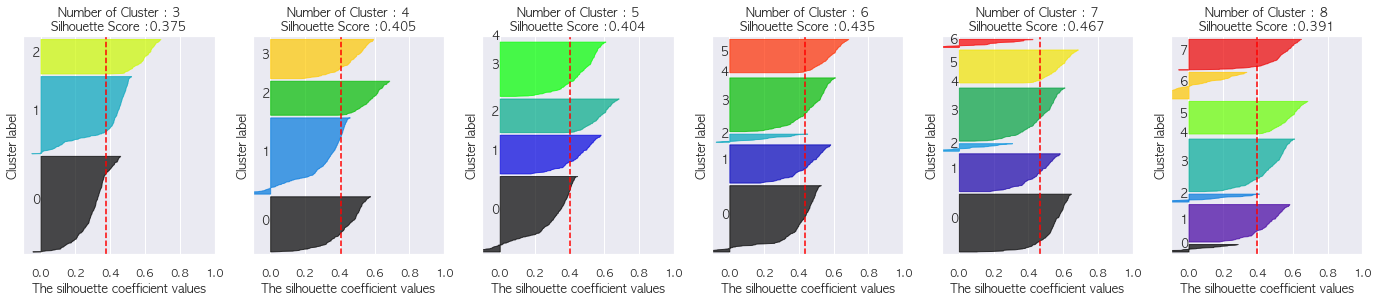

In [ ]:
# cluster 개수 2개, 3개, 4개, 5개 일때의 클러스터별 실루엣 계수 평균값을 시각화
visualize_silhouette([3,4,5,6,7,8], PCA_ds)

## 2-2. Clustering

[클러스터링 알고리즘] AgglomerativeClustering  

병합 군집 알고리즘은 시작할 때 각 포인트를 하나의 클러스터로 지정하고, 그다음 어떤 종료 조건을 만족할 때까지 가장 비슷한 두 클러스터를 합쳐나감.  
(linkage 옵션에서 가장 비슷한 클러스터를 측정하는 방법을 지정함 이 측정은 항상 두 클러스터 사이에서 이뤄짐)


[linkage='ward']  

기본값인 ward 연결(linkage)은 모든 클러스터 내의 분산을 가장 작게 증가시키는 두 클러스터를 합침 그래서 크기가 비교적 비슷한 클러스터가 만들어짐.  
(ward가 대부분의 데이터셋에 알맞음 클러스터에 속한 포인트 수가 많이 다를 땐 (한 클러스터가 다른 것보다 매우 클 때) average나 complete가 더 나을 수 있음)


In [247]:
np.random.seed(42)
AC = AgglomerativeClustering(n_clusters=7, linkage='ward')
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC

# Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= yhat_AC

## 2-3. Plot

### 2-3-1. Cluster별 Count

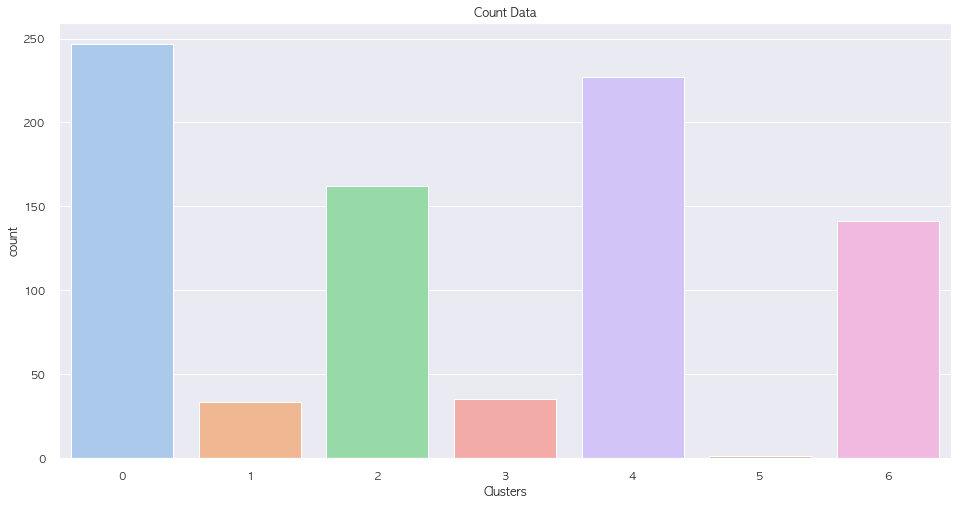

In [248]:
#Plotting countplot of clusters
# colors = ["red", "blue", "yellow"]
pl = sns.countplot(x=df["Clusters"], palette="pastel")
pl.set_title("Count Data")
plt.show()

### 2-3-2. 2차원 plot

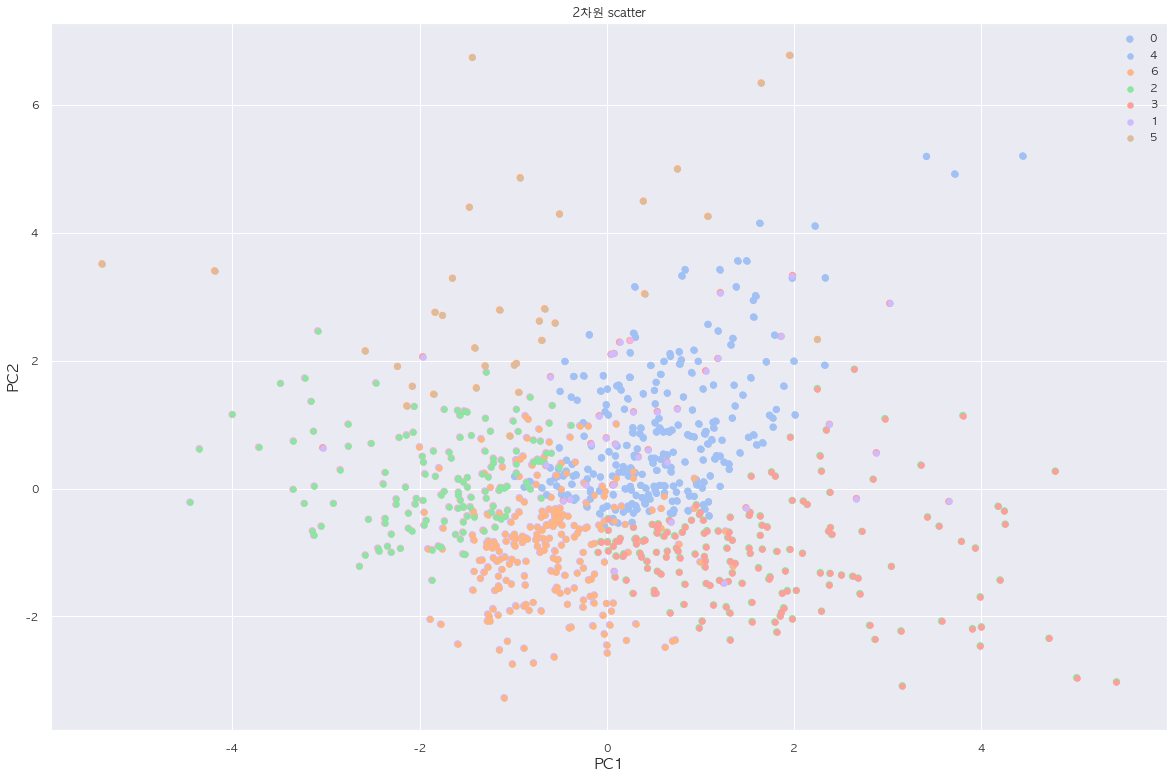

In [249]:
# Plotting the clusters / A 2D Projection Of Data In The Reduced Dimension
from matplotlib import colors
import matplotlib.font_manager as fm
import seaborn as sns

x_col = "PC1"
y_col = "PC2"

cmap = colors.ListedColormap(["#A1C0F4", "#FFB483", "#8CE5A1", "#FF9E9B", "#CFBBFF", "#DEBB9B", "#FAB0E4"])
labels = PCA_ds["Clusters"].unique().tolist()
colors = ["#A1C0F4", "#FFB483", "#8CE5A1", "#FF9E9B", "#CFBBFF", "#DEBB9B", "#FAB0E4"]

x =PCA_ds[x_col]; y =PCA_ds[y_col]
ig = plt.figure(figsize=(20,13))
ax = plt.subplot(111)
ax.scatter(x, y, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap)
ax.set_xlabel(x_col, fontsize = 15)
ax.set_ylabel(y_col, fontsize = 15)
ax.set_title("2차원 scatter")

for label, color in zip(labels, colors):
    indicesToKeep = (PCA_ds['Clusters'] == label)
    ax.scatter(PCA_ds.loc[indicesToKeep, x_col]
            , PCA_ds.loc[indicesToKeep, y_col], c = color, s = 30)

plt.legend(labels)
plt.show()

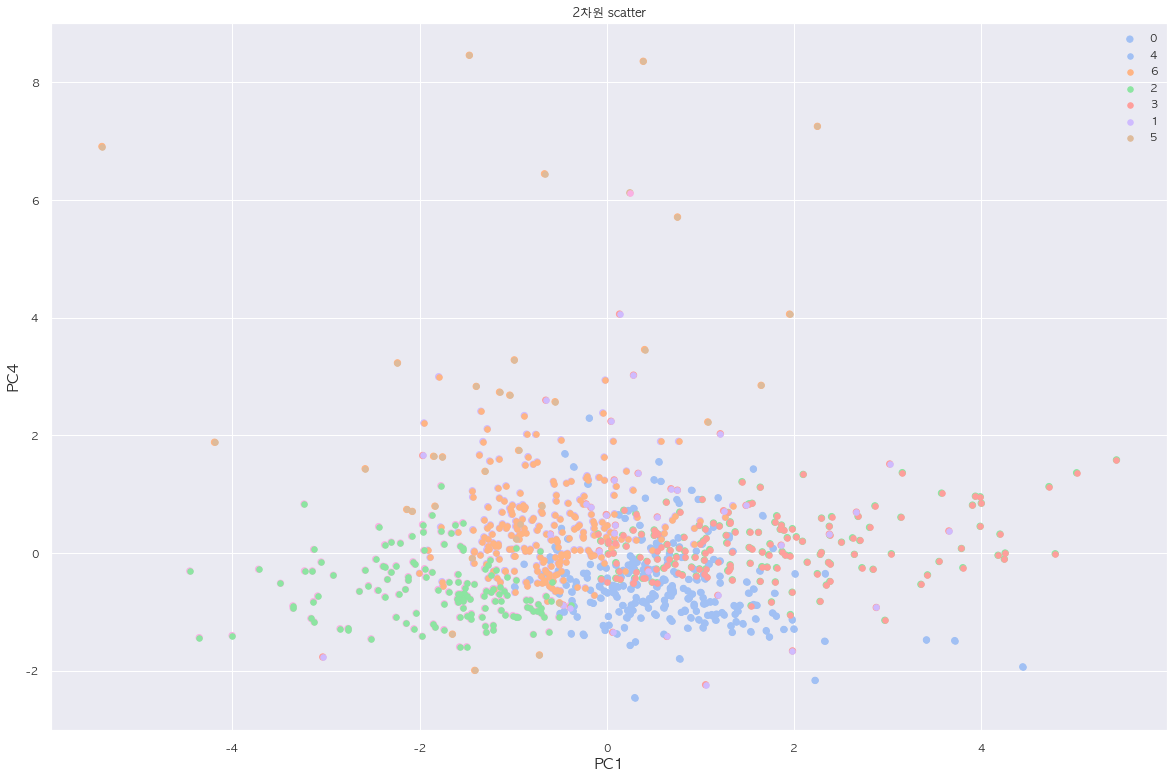

In [268]:
# Plotting the clusters / A 2D Projection Of Data In The Reduced Dimension
from matplotlib import colors
import matplotlib.font_manager as fm
import seaborn as sns

x_col = "PC1"
y_col = "PC4"

cmap = colors.ListedColormap(["#A1C0F4", "#FFB483", "#8CE5A1", "#FF9E9B", "#CFBBFF", "#DEBB9B", "#FAB0E4"])
labels = PCA_ds["Clusters"].unique().tolist()
colors = ["#A1C0F4", "#FFB483", "#8CE5A1", "#FF9E9B", "#CFBBFF", "#DEBB9B", "#FAB0E4"]

x =PCA_ds[x_col]; y =PCA_ds[y_col]
ig = plt.figure(figsize=(20,13))
ax = plt.subplot(111)
ax.scatter(x, y, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap)
ax.set_xlabel(x_col, fontsize = 15)
ax.set_ylabel(y_col, fontsize = 15)
ax.set_title("2차원 scatter")

for label, color in zip(labels, colors):
    indicesToKeep = (PCA_ds['Clusters'] == label)
    ax.scatter(PCA_ds.loc[indicesToKeep, x_col]
            , PCA_ds.loc[indicesToKeep, y_col], c = color, s = 30)

plt.legend(labels)
plt.show()

### 2-3-3. 3차원 plot

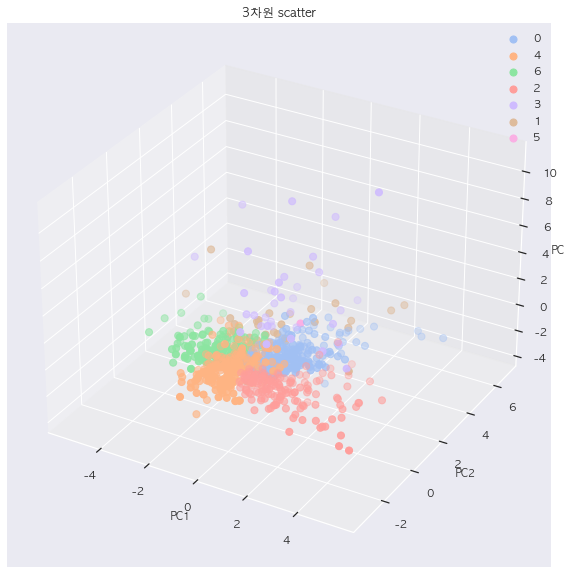

In [259]:
# Plotting the clusters / A 3D Projection Of Data In The Reduced Dimension

x_col = "PC1"
y_col = "PC2"
z_col = "PC3"

labels = PCA_ds["Clusters"].unique().tolist()
colors = ["#A1C0F4", "#FFB483", "#8CE5A1", "#FF9E9B", "#CFBBFF", "#DEBB9B", "#FAB0E4"]

x =PCA_ds[x_col]; y =PCA_ds[y_col]; z =PCA_ds[z_col]
fig = plt.figure(figsize=(50,10))
ax = plt.subplot(111, projection='3d')
ax.set_xlabel(x_col, fontsize = 10)
ax.set_ylabel(y_col, fontsize = 10)
ax.set_zlabel(z_col, fontsize = 10)
ax.set_title("3차원 scatter")

for label, color in zip(labels, colors):
    indicesToKeep = (PCA_ds['Clusters'] == label)
    ax.scatter(PCA_ds.loc[indicesToKeep, x_col]
            , PCA_ds.loc[indicesToKeep, y_col]
            , PCA_ds.loc[indicesToKeep, z_col], c = color, s = 50)

plt.legend(labels)
plt.show()

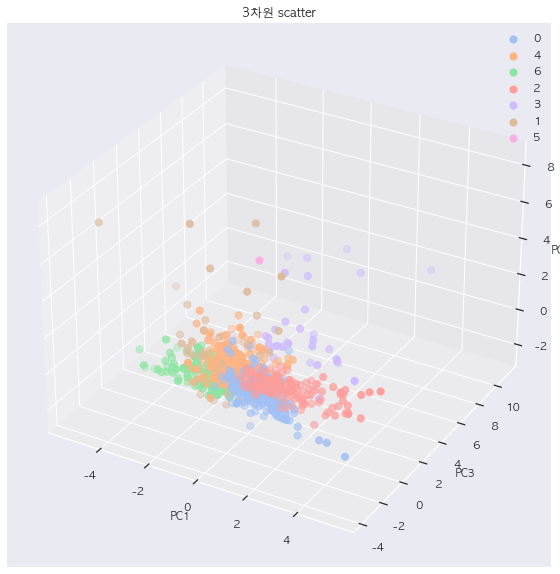

In [279]:
# Plotting the clusters / A 3D Projection Of Data In The Reduced Dimension

x_col = "PC1"
y_col = "PC3"
z_col = "PC4"

labels = PCA_ds["Clusters"].unique().tolist()
colors = ["#A1C0F4", "#FFB483", "#8CE5A1", "#FF9E9B", "#CFBBFF", "#DEBB9B", "#FAB0E4"]

x =PCA_ds[x_col]; y =PCA_ds[y_col]; z =PCA_ds[z_col]
fig = plt.figure(figsize=(50,10))
ax = plt.subplot(111, projection='3d')
ax.set_xlabel(x_col, fontsize = 10)
ax.set_ylabel(y_col, fontsize = 10)
ax.set_zlabel(z_col, fontsize = 10)
ax.set_title("3차원 scatter")

for label, color in zip(labels, colors):
    indicesToKeep = (PCA_ds['Clusters'] == label)
    ax.scatter(PCA_ds.loc[indicesToKeep, x_col]
            , PCA_ds.loc[indicesToKeep, y_col]
            , PCA_ds.loc[indicesToKeep, z_col], c = color, s = 50)

plt.legend(labels)
plt.show()